In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GRU, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data
file_path =r'C:\Users\TECH 23\PycharmProjects\Flood_Detection\Lag_Weather.csv'
data = pd.read_csv(file_path)

In [3]:
# Convert the 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

In [4]:
# Handling missing values by forward filling
data.fillna(method='ffill', inplace=True)

In [5]:
# Calculate cumulative rainfall over the past 7 days
data['precip'] = data['precip'].fillna(0)  # Use the correct column name 'precip'
data['cumulative_rainfall'] = data['precip'].rolling(window=7).sum()

In [6]:
# Create a binary flood indicator based on conditions (e.g., rain, thunderstorms)
data['flood'] = data['conditions'].apply(lambda x: 1 if 'rain' in x.lower() or 'thunderstorm' in x.lower() else 0)

# Select relevant columns
selected_columns = ['datetime', 'tempmax', 'tempmin', 'temp', 'humidity', 'dew', 'windspeed', 'windgust', 'cumulative_rainfall', 'flood']
data_selected = data[selected_columns]

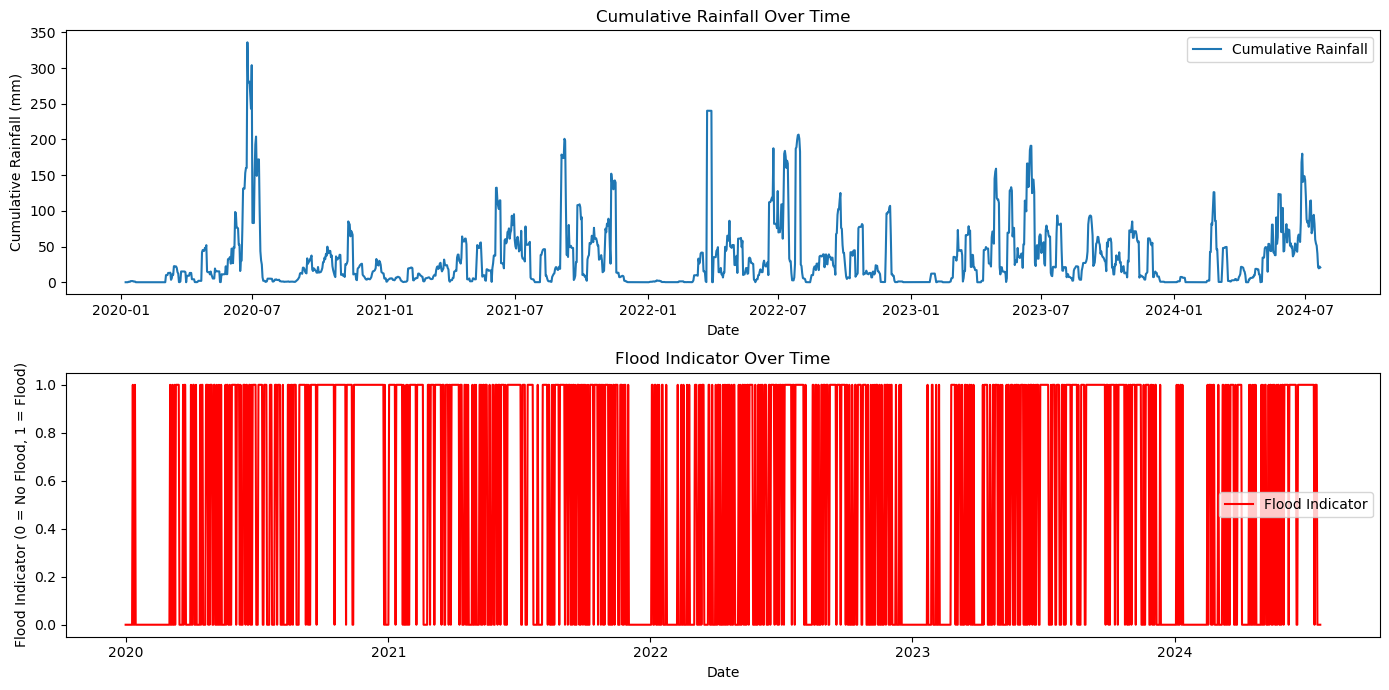

In [7]:
# Step 2: Plot cumulative rainfall and flood indicator
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data['datetime'], data['cumulative_rainfall'], label='Cumulative Rainfall')
plt.title('Cumulative Rainfall Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Rainfall (mm)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['datetime'], data['flood'], label='Flood Indicator', color='r')
plt.title('Flood Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('Flood Indicator (0 = No Flood, 1 = Flood)')
plt.legend()

plt.tight_layout()
plt.savefig('cumulative_rainfall_flood_indicator.png')
plt.show()


In [8]:
# Step 3: Define features and target
X = data_selected[['tempmax', 'tempmin', 'temp', 'humidity', 'dew', 'windspeed', 'windgust', 'cumulative_rainfall']]
y = data_selected['flood']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Calculate cumulative rainfall over the past 7 days
data['precip'] = data['precip'].fillna(0)
data['cumulative_rainfall'] = data['precip'].rolling(window=7).sum()

# Create a binary flood indicator based on conditions (e.g., rain, thunderstorms)
data['flood'] = data['conditions'].apply(lambda x: 1 if 'rain' in x.lower() or 'thunderstorm' in x.lower() else 0)

# Select relevant columns
selected_columns = ['datetime', 'tempmax', 'tempmin', 'temp', 'humidity', 'dew', 'windspeed', 'windgust', 'cumulative_rainfall', 'flood']
data_selected = data[selected_columns].dropna()


In [10]:
# Convert the 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Handling missing values by forward filling
data.fillna(method='ffill', inplace=True)


In [11]:
# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_selected[['tempmax', 'tempmin', 'temp', 'humidity', 'dew', 'windspeed', 'windgust', 'cumulative_rainfall']])

# Prepare sequences for the CNN-GRU model
def create_sequences(data, target, sequence_length=7):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 7
X, y = create_sequences(scaled_data, data_selected['flood'].values, sequence_length)


In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN-GRU model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=32))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
33/33 [==============================] - 5s 36ms/step - loss: 0.6841 - accuracy: 0.5729 - val_loss: 0.6507 - val_accuracy: 0.6491
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.6386 - accuracy: 0.6411 - val_loss: 0.6073 - val_accuracy: 0.6642
Epoch 3/20
33/33 [==============================] - 0s 6ms/step - loss: 0.6293 - accuracy: 0.6364 - val_loss: 0.6320 - val_accuracy: 0.6491
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.6233 - accuracy: 0.6506 - val_loss: 0.6124 - val_accuracy: 0.6604
Epoch 5/20
33/33 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6733 - val_loss: 0.5938 - val_accuracy: 0.6453
Epoch 6/20
33/33 [==============================] - 0s 6ms/step - loss: 0.6229 - accuracy: 0.6449 - val_loss: 0.5920 - val_accuracy: 0.6528
Epoch 7/20
33/33 [==============================] - 0s 7ms/step - loss: 0.6172 - accuracy: 0.6600 - val_loss: 0.5867 - val_accuracy: 0.6604
Epoch 8/20
33/33 [=

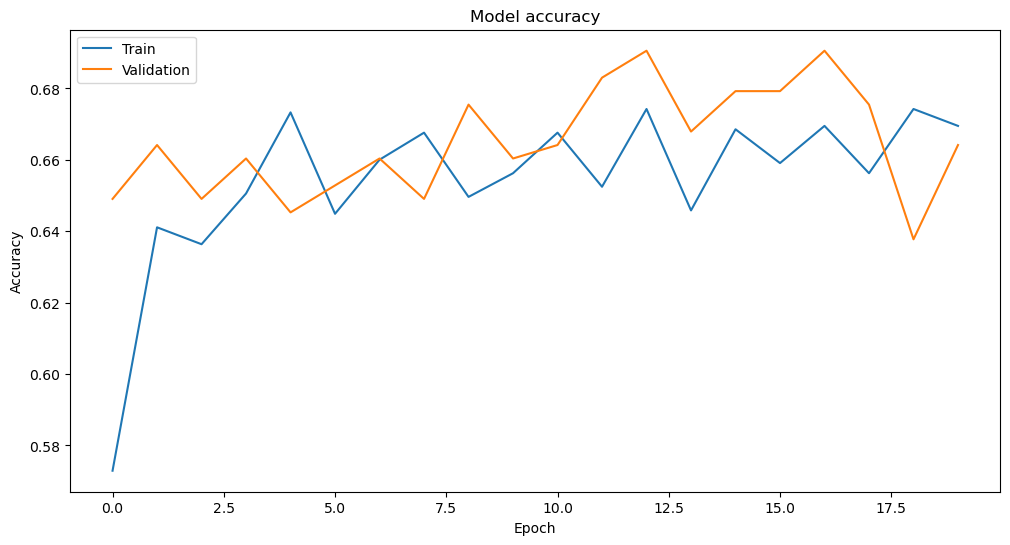

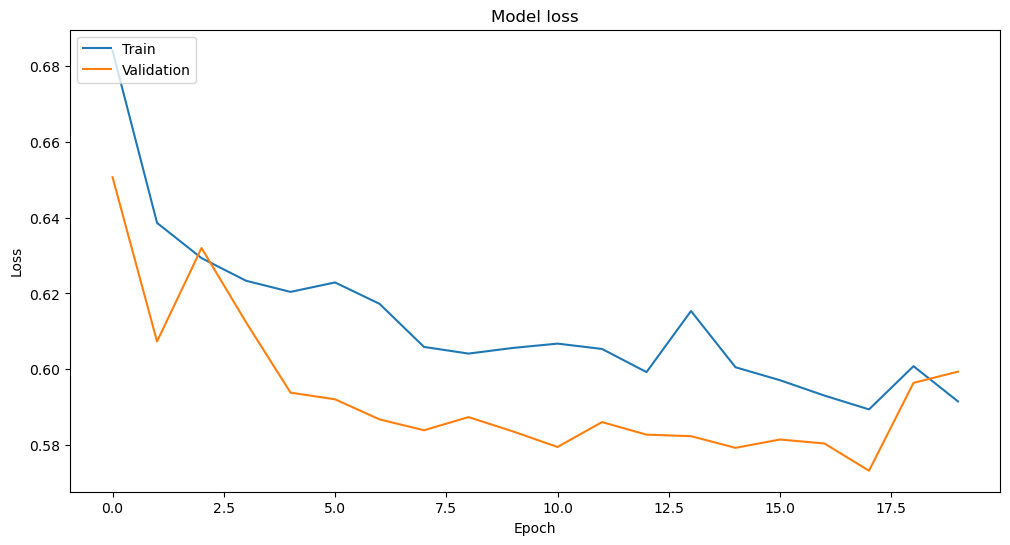

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Make predictions
predictions = model.predict(X_test)
predicted_floods = (predictions > 0.5).astype(int)

11/11 [==============================] - 1s 3ms/step


In [16]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, predicted_floods)
precision = precision_score(y_test, predicted_floods)
recall = recall_score(y_test, predicted_floods)
f1 = f1_score(y_test, predicted_floods)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.6344410876132931
Precision: 0.6063829787234043
Recall: 0.9447513812154696
F1 Score: 0.7386609071274297


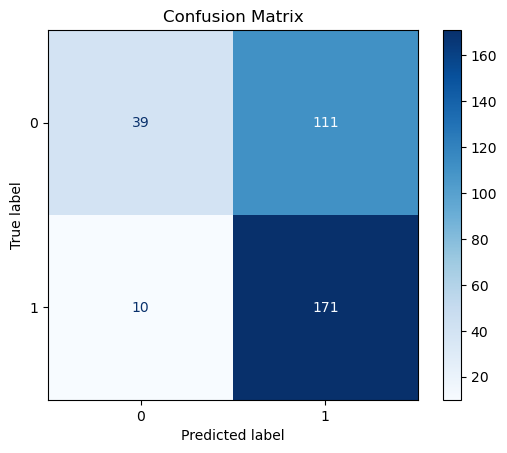

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, predicted_floods)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Predict future floods
last_sequence = scaled_data[-sequence_length:]
future_flood_predictions = []

for _ in range(30):  # Predict next 30 days
    next_flood_prob = model.predict(np.expand_dims(last_sequence, axis=0))
    future_flood_predictions.append(next_flood_prob)
    next_sequence = np.roll(last_sequence, -1, axis=0)
    next_sequence[-1] = next_flood_prob

future_dates = pd.date_range(start=data_selected['datetime'].max() + pd.Timedelta(days=1), periods=30, freq='D')
future_flood_predictions = np.array(future_flood_predictions).flatten()
future_floods = (future_flood_predictions > 0.5).astype(int)

predicted_flood_dates = future_dates[future_floods == 1]

print("Predicted flood dates:")
print(predicted_flood_dates)

1/1 [==============================] - 0s 24ms/step
Predicted flood dates:
DatetimeIndex(['2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26',
               '2024-07-27', '2024-07-28', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-03',
               '2024-08-04', '2024-08-05', '2024-08-06', '2024-08-07',
               '2024-08-08', '2024-08-09', '2024-08-10', '2024-08-11',
               '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15',
               '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19',
               '2024-08-20', '2024-08-21'],
              dtype='datetime64[ns]', freq='D')
